In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import mavenn

%matplotlib notebook

In [2]:
def my_rsquared(x,y, bootstrap_samples=100):
    """Returns R^2 and SE thereof based on bootstrap resampling"""
    r2 = pearsonr(x,y)[0]**2 # pingouin.corr(x, y).loc['pearson','r']**2
    N = len(x)
    assert len(x)==len(y), f'len(x)={len(x)} and len(y)={len(y)} are not the same.'
    r2s = np.zeros(bootstrap_samples)
    for i in range(bootstrap_samples):
        ix = np.random.choice(a=bootstrap_samples, size=bootstrap_samples, replace=True)
        r2s[i] = pearsonr(x[ix],y[ix])[0]**2 #pingouin.corr(x[ix], y[ix]).loc['pearson','r']**2
    dr2 = np.std(r2s)
    return r2, dr2

In [3]:
style_file_name = 'figS5.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)
plt.rc('font', family='sans-serif')
plt.rc('font', family='sans-serif')

In [4]:
## Define OtwinowskiGPMapLayer

# Standard TensorFlow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

# Import base class
from mavenn.src.layers.gpmap import GPMapLayer

# Define custom G-P map layer
class OtwinowskiGPMapLayer(GPMapLayer):
    """
    A G-P map representing the thermodynamic model described by
    Otwinowski (2018).
    """

    def __init__(self, *args, **kwargs):
        """Construct layer instance."""

        # Call superclass constructor
        # Sets self.L, self.C, and self.regularizer
        super().__init__(*args, **kwargs)
        
        # Initialize constant parameter for folding energy
        self.theta_f_0 = self.add_weight(name='theta_f_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize constant parameter for binding energy
        self.theta_b_0 = self.add_weight(name='theta_b_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize additive parameter for folding energy
        self.theta_f_lc = self.add_weight(name='theta_f_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # Initialize additive parameter for binding energy
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

    def call(self, x_lc):
        """Compute phi given x."""

        # 1kT = 0.582 kcal/mol at room temperature
        kT = 0.582

        # Reshape input to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # Compute Delta G for binding
        Delta_G_b = self.theta_b_0 + \
                    tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
            
        # Compute Delta G for folding
        Delta_G_f = self.theta_f_0 + \
                    tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
        
        # Compute and return fraction folded and bound
        Z = 1+K.exp(-Delta_G_f/kT)+K.exp(-(Delta_G_f+Delta_G_b)/kT)
        p_bf = (K.exp(-(Delta_G_f+Delta_G_b)/kT))/Z
        phi = p_bf #K.log(p_bf)/np.log(2)
        return phi

In [5]:
# Load GB1 model
model = mavenn.load('../models/gb1_custom_lr_0.002_e_3000_ge_full_2021.12.28.12h.41m')

# Get wt sequence
wt_seq = model.x_stats['consensus_seq']
wt_lc = mavenn.src.utils.x_to_ohe(wt_seq, alphabet=model.alphabet).reshape([model.L, model.C])

# Get parameters
theta_dict = model.layer_gpmap.get_params()
dG_f_mat_mavenn = theta_dict['theta_f_lc']

# Compute ddGs
ddG_f_mat_mavenn = dG_f_mat_mavenn - (dG_f_mat_mavenn*wt_lc).sum(axis=1)[:,np.newaxis]

Model loaded from these files:
	../models/gb1_custom_lr_0.002_e_3000_ge_full_2021.12.28.12h.41m.pickle
	../models/gb1_custom_lr_0.002_e_3000_ge_full_2021.12.28.12h.41m.h5


In [6]:
# Load Otwinowski parameters
dG_f_otwinowski_df = pd.read_csv('../../mavenn/examples/datasets/raw/otwinowski_gf_data.csv.gz', index_col=[0]).T.reset_index(drop=True)[model.alphabet]
ddG_f_mat_otwinowski = dG_f_otwinowski_df.values - \
                       np.sum(wt_lc*dG_f_otwinowski_df.values, axis=1)[:,np.newaxis]

<IPython.core.display.Javascript object>


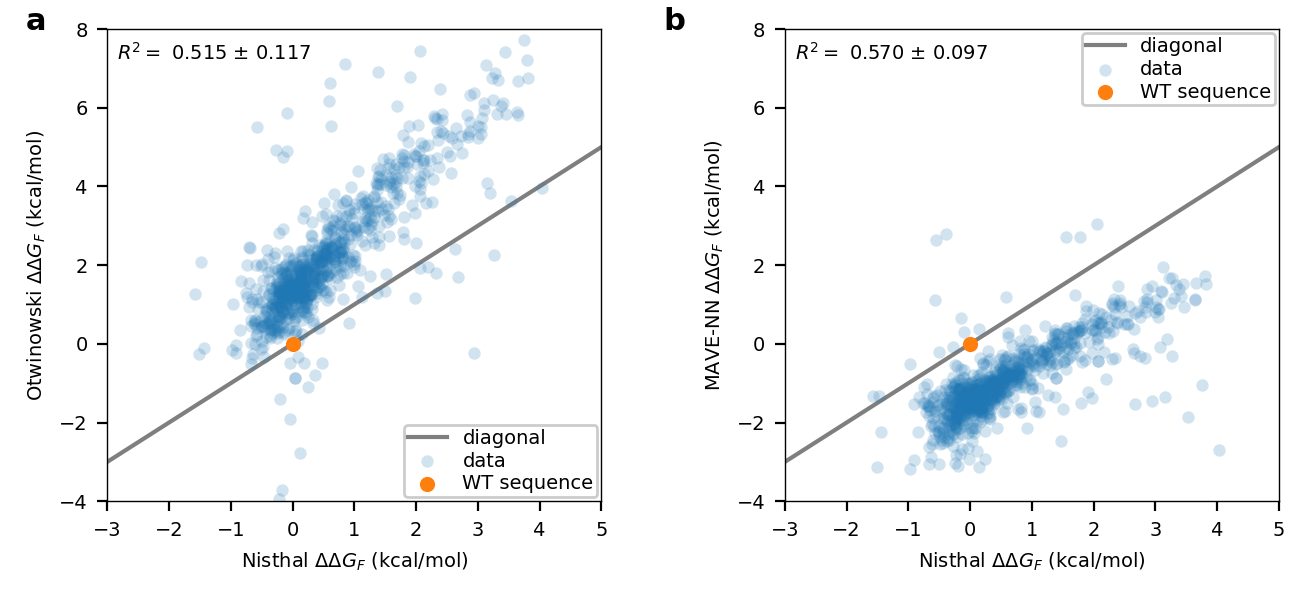

In [7]:
# Load Nisthal data
nisthal_df = mavenn.load_example_dataset('nisthal')
nisthal_df.set_index('x', inplace=True)

# Get Nisthal folding energies relative to WT
dG_f_nisthal = nisthal_df['y']
dG_f_wt_nisthal = dG_f_nisthal[wt_seq]
ddG_f_nisthal = dG_f_nisthal - dG_f_wt_nisthal

# Get MAVE-NN folding energies relative to WT
x_nisthal = nisthal_df.index.values
x_nisthal_ohe = mavenn.src.utils.x_to_ohe(x=x_nisthal,
                                          alphabet=model.alphabet)
ddG_f_vec = ddG_f_mat_mavenn.ravel().reshape([1,-1])
ddG_f_mavenn = np.sum(ddG_f_vec*x_nisthal_ohe, axis=1)

# Get Otwinowski folding energies relative to WT
ddG_f_vec_otwinowski = ddG_f_mat_otwinowski.ravel().reshape([1,-1])
ddG_f_otwinowski = np.sum(ddG_f_vec_otwinowski*x_nisthal_ohe, axis=1)

# Define plotting routine
def draw(ax, y, model_name, loc):
    r2, dr2 = my_rsquared(ddG_f_nisthal, y)
    ax.scatter(ddG_f_nisthal, y, alpha=.2, label='data', s=20, linewidth=0)
    ax.scatter(0,0, label='WT sequence', s=30, linewidth=0)
    xlim = [-3,5]
    ylim = [-4,8]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(xlim, xlim, color='k', alpha=.5, label='diagonal', zorder=-100)
    ax.set_xlabel(f'Nisthal $\Delta \Delta G_F$ (kcal/mol)')
    ax.set_ylabel(f'{model_name} $\Delta \Delta G_F$ (kcal/mol)')
    ax.legend(loc=loc)
    
    # Display r^2
    yint = ylim[1]-ylim[0]
    xint = xlim[1]-xlim[0]
    ax.text(x=xlim[0]+.02*xint, 
            y=ylim[1]-.05*yint,
            s=f'$R^2 =$ {r2:.3f} $\pm$ {dr2:.3f}', 
            ha='left', va='center');
    
# Make figure
fig = plt.figure(figsize=[6.5, 3])
plt.style.use(style_file_name)
gs = fig.add_gridspec(1, 2)

# Define panels
ax_a = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[0, 1])

draw(ax=ax_a,
     y=ddG_f_otwinowski,
     model_name='Otwinowski',
     loc='lower right')
draw(ax=ax_b,
     y=ddG_f_mavenn,
     model_name='MAVE-NN',
     loc='upper right')

# Add panel labels
fig.text(0.02, 0.95, 'a', fontsize=11, fontweight='bold')
fig.text(0.51, 0.95, 'b', fontsize=11, fontweight='bold')

# Clean up and save
fig.tight_layout(w_pad=5)
fig.savefig('png/figS5_ipynb.png', dpi=400, facecolor='w')